In [1]:
using Plots, NLsolve, Roots, Interpolations, Optim, Random, CSV, DataFrames
using Parameters, QuantEcon, Distributions, StatsBase, Statistics
include("./code/twoskills.jl");

### External Parameters

In [2]:
const α = 0.64 # labor share
const γ = 0.4 # intensive Frish elasticity
const hbar = 1/3 # hours worked
const amin = 0 # asset lower bound
const curv = 1.7 # asset grid curvature
const δ = 0.025 # depreciation ratio (quarterly)
const θ = 1.43 # constant elasticity btw skilled and unskilled (Katz and Murphy 1992)
const ne = 2 # number of skill grid
const ρx = 0.929 # persistence of labor productivity shocks (Chang and Kim 2006)
const σx = 0.227 # volatility of labor productivity shocks (Chang and Kim 2006)
const srate = 0.47; # population ratio of skilled (skilled / (unskilled + skilled), CPS 2019.Q4)

### Target Moments (CPS 2019.Q4)
- Skilled Employment Rate = 0.74 by `Bu` (disutility of the unskilled)
- Unkilled Employment Rate = 0.87 by `Bs` (disutility of the skilled)
- Wage Discount = 0.53 by `s` (skill demand)
- Interest rate = 0.01 by `β` (time discount rate)

In [3]:
Data_empu = 0.74 # unskilled employment rate
Data_emps = 0.87 # skilled employment rate
Data_wdis = 0.54 # wage discount
Data_rate = 1.00; # interate rate

### Internal Parameters

In [4]:
# from CES production function 
s = 0.35 # match skill wage gap wu / ws = 0.54
β = 0.98898; # irate = 1.00%
Bu = 156.9 # unskilled emp rate = 0.74
Bs = 138.3; # skilled = emp rate 0.87

### Grids

In [5]:
# Asset
amax = 25.0;
na = 101 # number of asset grids
agrid = [amin + amax * ((ia-1)/(na-1)) ^ curv for ia in 1:na];

# Productivity
nz = 61 # number of labor prod shocks
ezgrid = exp.(range(-3 * σx, 3 * σx, length = nz));
mc = tauchen(nz, ρx, σx * sqrt(1 - ρx ^ 2), 0);
Π = mc.p;
SSprob = stationary_distributions(mc)[1];

### Initial Values

In [8]:
init_VE = zeros(ne,na,nz)
init_VN = zeros(ne,na,nz)
init_μ = zeros(ne,na,nz)
init_μ[1,:,:] = repeat(transpose(SSprob), na) / na * (1-srate)
init_μ[2,:,:] = repeat(transpose(SSprob), na) / na * srate

init_Lu = 0.1413257388233078
init_Ls = 0.1421088292427011
init_K  = 5.402382294430006;

In [9]:
@time VE, VN, AS, HR, CS, μ, Lu, Ls, K = SteadyState(
    init_VE, init_VN, init_μ, init_Lu, init_Ls, init_K,
    β, s, na, nz, Bu, Bs, amax, agrid, ezgrid, Π, TV,
    VFI, Tμ, μFI, findLK; tol = 0.01, convex_combi=0.05);

Lu = 0.1413257388233078
Ls = 0.1421088292427011
K  = 5.402382294430006
------------------------------------------------------
finkLK
VFI
38.96507057373909
0.017147533493499623
6.797792775614653e-5
μFI
5.794339387057713
5.318410336648169
------------------------------------------------------
dampening factor: 0.055
current difference: 0.12767804
current empu: 0.70045713
current emps: 0.84435923
current wdis: 0.5411437
current rate: 0.99877449
------------------------------------------------------
Lu = 0.1410604055092499
Ls = 0.1420662612682714
K  = 5.410851885638268
------------------------------------------------------
finkLK
VFI
0.006882572337133297
μFI
5.60631503127176
5.358041967639967
------------------------------------------------------
dampening factor: 0.0605
current difference: 0.07098147
current empu: 0.70964314
current emps: 0.84657984
current wdis: 0.54157274
current rate: 0.99567176
------------------------------------------------------
Lu = 0.140873442388664
Ls = 0.142038

### Model Implied Values

In [10]:
L = (s * Lu ^ ((θ-1)/θ) + (1-s) * Ls ^ ((θ-1)/θ)) ^ (θ/(θ-1))
wu = α * (K/L) ^ (1-α) * s * (L/Lu) ^ (1/θ)
ws = α * (K/L) ^ (1-α) * (1-s) * (L/Ls) ^ (1/θ)

Model_empu = sum(μ[1,:,:] .* (HR[1,:,:] .> 0)) / sum(μ[1,:,:])
Model_emps = sum(μ[2,:,:] .* (HR[2,:,:] .> 0)) / sum(μ[2,:,:])
Model_wdis = wu/ws
Model_rate = (1 - α) * (L / K) ^ α - δ

println("==================[Data VS Model]===================")
println("Emp of Unskilled   : (Model) $(round(Model_empu, digits=2))   VS   (Data) $Data_empu")
println("Emp of Skilled     : (Model) $(round(Model_emps, digits=2))   VS   (Data) $Data_emps")
println("Wage Discount      : (Model) $(round(Model_wdis, digits=2))   VS   (Data) $Data_wdis")
println("Interate Rate      : (Model) $(round(Model_rate*100, digits=2))   VS   (Data) $Data_rate")

==================[Data VS Model]===================
Emp of Unskilled   : (Model) 0.73   VS   (Data) 0.74
Emp of Skilled     : (Model) 0.85   VS   (Data) 0.87
Wage Discount      : (Model) 0.54   VS   (Data) 0.54
Interate Rate      : (Model) 1.01   VS   (Data) 1.0


### Check the Distribution of the unskilled

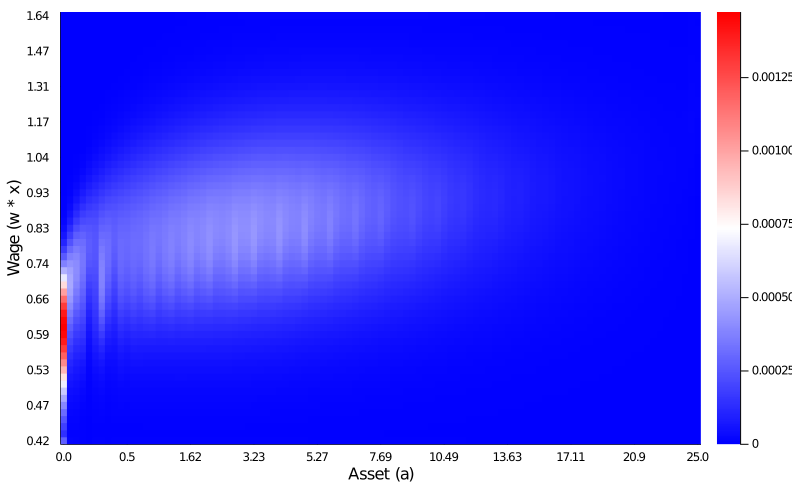

In [14]:
heatmap(transpose(μ[1,:,:]), c=cgrad([:blue, :white, :red]), xlabel = "Asset (a)", ylabel = "Wage (w * x)",
    yticks=(1:5:nz, round.(wu .* ezgrid[1:5:nz], digits=2)),
    xticks=(1:10:na, round.(agrid[1:10:na], digits=2)), size=(na*7.85,nz*8))

### Check the Distribution of the Skilled

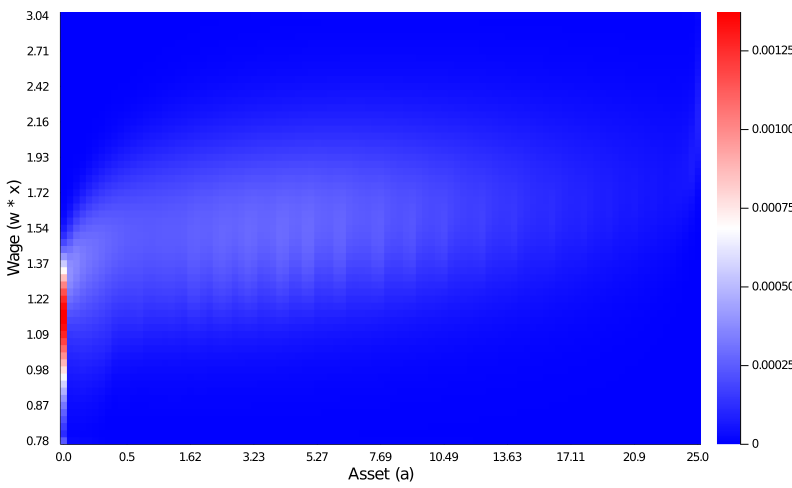

In [15]:
heatmap(transpose(μ[2,:,:]), c=cgrad([:blue, :white, :red]), xlabel = "Asset (a)", ylabel = "Wage (w * x)",
    yticks=(1:5:nz, round.(ws .* ezgrid[1:5:nz], digits=2)),
    xticks=(1:10:na, round.(agrid[1:10:na], digits=2)), size=(na*7.85,nz*8))

### Save the Results

In [18]:
CSV.write("./output/twoskills/VEU.csv", DataFrame(VE[1,:,:]))
CSV.write("./output/twoskills/VNU.csv", DataFrame(VN[1,:,:]))
CSV.write("./output/twoskills/ASU.csv", DataFrame(AS[1,:,:]))
CSV.write("./output/twoskills/HRU.csv", DataFrame(HR[1,:,:]))
CSV.write("./output/twoskills/CSU.csv", DataFrame(CS[1,:,:]))
CSV.write("./output/twoskills/MUU.csv", DataFrame(μ[1,:,:]));

CSV.write("./output/twoskills/VES.csv", DataFrame(VE[2,:,:]))
CSV.write("./output/twoskills/VNS.csv", DataFrame(VN[2,:,:]))
CSV.write("./output/twoskills/ASS.csv", DataFrame(AS[2,:,:]))
CSV.write("./output/twoskills/HRS.csv", DataFrame(HR[2,:,:]))
CSV.write("./output/twoskills/CSS.csv", DataFrame(CS[2,:,:]))
CSV.write("./output/twoskills/MUS.csv", DataFrame(μ[2,:,:]));